# Import python libraries and data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_curve, r2_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import joblib

In [ ]:
df = pd.read_csv('/churn_dataset.csv')
df = df.drop(['Unnamed: 0'], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   tenure                               7032 non-null   int64  
 1   PhoneService                         7032 non-null   int64  
 2   PaperlessBilling                     7032 non-null   int64  
 3   MonthlyCharges                       7032 non-null   float64
 4   TotalCharges                         7032 non-null   float64
 5   Churn                                7032 non-null   int64  
 6   MultipleLines                        7032 non-null   int64  
 7   OnlineSecurity                       7032 non-null   int64  
 8   OnlineBackup                         7032 non-null   int64  
 9   DeviceProtection                     7032 non-null   int64  
 10  TechSupport                          7032 non-null   int64  
 11  StreamingTV                   

In [ ]:
#Creating dataframe for both numeric and categorical features
df_num = df[['tenure','MonthlyCharges','TotalCharges']]

In [ ]:
#Calculating the first and third quantile of the "TotalCharges" columns
q1 = df_num['TotalCharges'].quantile(0.25)
q3 = df_num['TotalCharges'].quantile(0.75)

#Calculating the Interquantile range (IQR)
IQR = q3 - q1

#Calculating the lower and upper bound
lower_bound = q1 - (IQR * 1.5)
upper_bound = q3 + (IQR * 1.5)

#Checking if the values of the column lies between the lower and upper bound
df_num['TotalCharges'].min() > lower_bound and df_num['TotalCharges'].max() < upper_bound

True

In [ ]:
#Scaling the dataframe
scaler = MinMaxScaler()
Scaled = scaler.fit_transform(df_num)

#Converting the scaled data back to the dataframe form
df_nums = pd.DataFrame(Scaled,columns= ['Tenure','monthlyCharges','totalCharges'],index=df_num.index)

In [ ]:
df = pd.concat([df, df_nums], axis=1)
df.drop(df[['tenure','MonthlyCharges','TotalCharges']],axis=1,inplace=True)

# Train-Test split

In [ ]:
Y = df["Churn"]
X = df.drop(['Churn'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state = 0)

In [ ]:
print('features_train:',X_train.shape), print('target_train: ',Y_train.shape)
print('features_test: ',X_train.shape), print('target_test: ',Y_train.shape)

features_train: (5274, 23)
target_train:  (5274,)
features_test:  (5274, 23)
target_test:  (5274,)


(None, None)

# Cluster Model

In [ ]:
df_clusters = df.drop(['Churn'], axis=1)
distortion = []
K = range(1, 8) 
for k in K:
    model = KMeans(n_clusters=k, random_state=10)
    model.fit(df_clusters)
    distortion.append(model.inertia_) #inertia: how spread out the clusters are distance from each sample

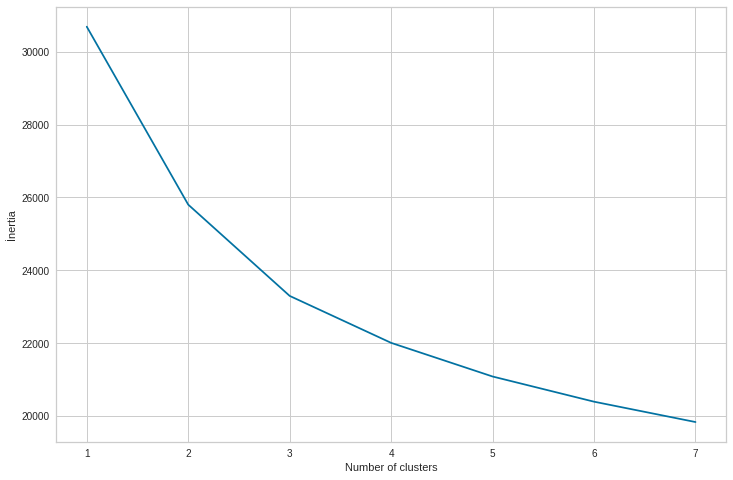

In [ ]:
# create cluster graph using 1-8 clusters number
plt.figure(figsize=(12, 8))
plt.plot(K, distortion, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('İnertia')
plt.show()

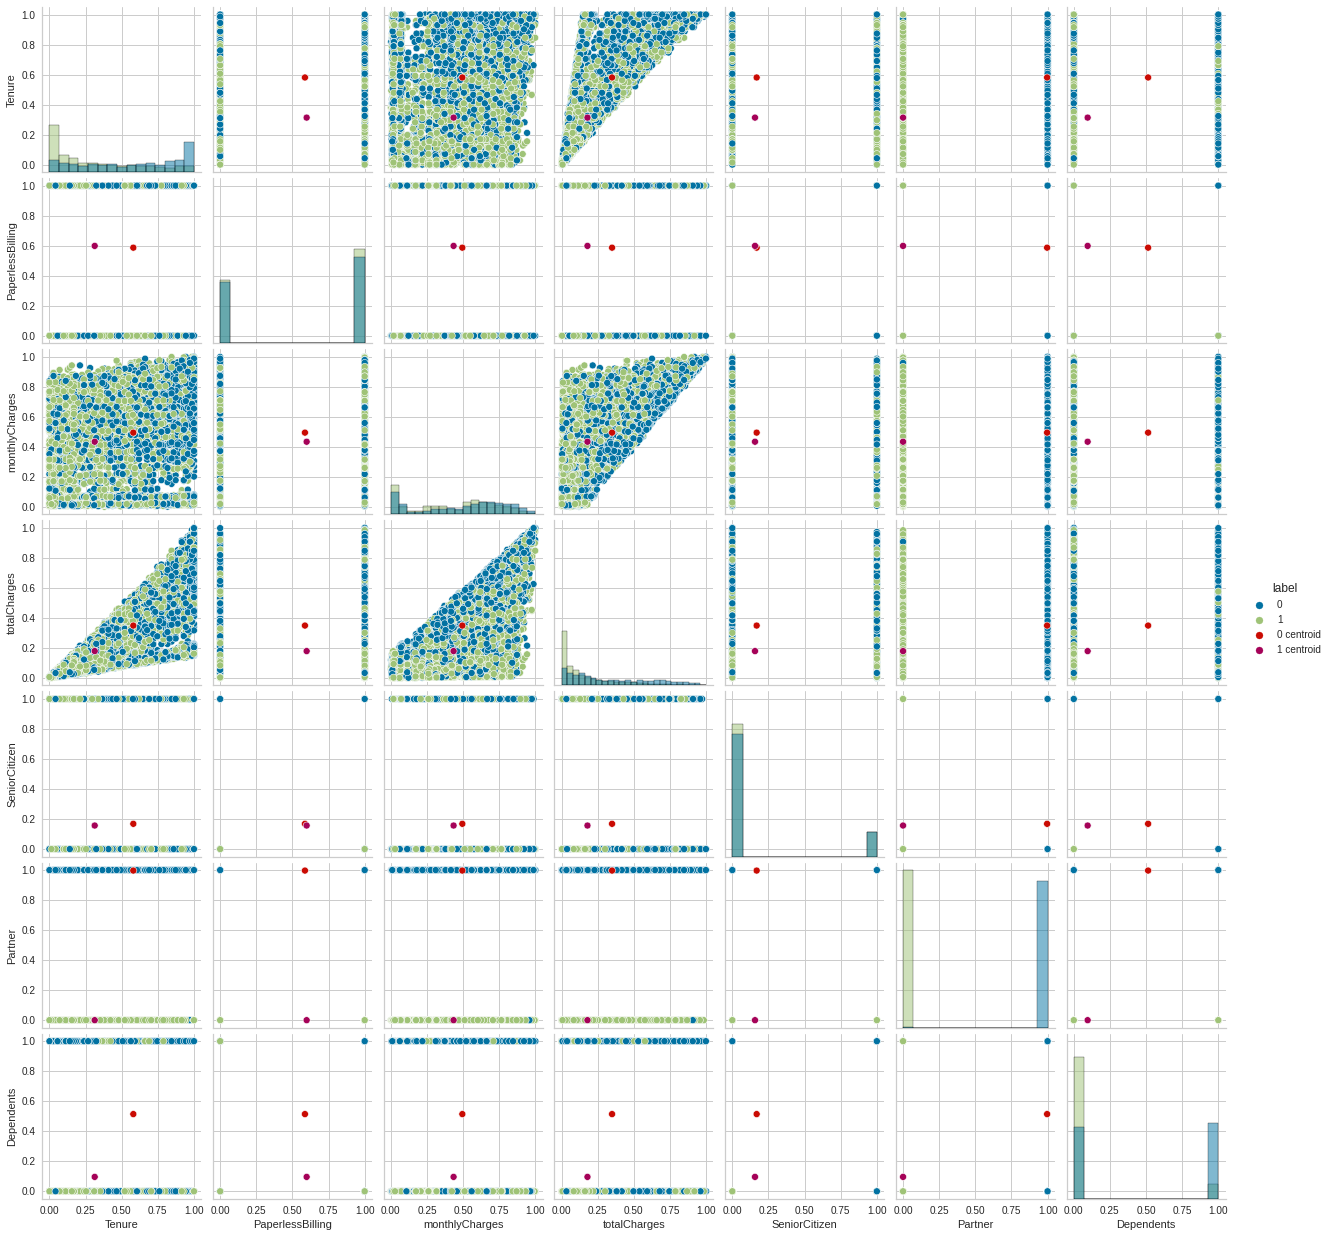

In [ ]:
# Training a model for 2 clusters        
df_clusters = df_clusters[['Tenure','PaperlessBilling', 'monthlyCharges', 'totalCharges','SeniorCitizen','Partner','Dependents']]
scaler = MinMaxScaler()

scaler.fit_transform(df_clusters)


model = KMeans(n_clusters=2, random_state=0)
model.fit(df_clusters)
centroids = pd.DataFrame(model.cluster_centers_, columns=df_clusters.columns)
df_clusters['label'] = model.labels_.astype(str)
centroids['label'] = ['0 centroid', '1 centroid']
data_all = pd.concat([df_clusters, centroids], ignore_index=True)

# Plot the graph
sns.pairplot(data_all, hue='label', diag_kind='hist')

# ML Modelling


In [ ]:
#Storing ML algorithms in a list for iteration
algos = [RandomForestClassifier(random_state=42),AdaBoostClassifier(),DecisionTreeClassifier(),
         SVC(),GradientBoostingClassifier(),XGBClassifier(),KNeighborsClassifier()]

#Creating dictionary to store accuracy values for each model
dic = {}

#Iteration through each algorithm to create models
for algo in algos:
    model = Pipeline([
        ('Scaler',StandardScaler()),
        ('model',algo)
    ])
    model.fit(X_train,Y_train)
    y_pred = model.predict(X_test)
    algo = str(algo)
    acc = accuracy_score(Y_test,y_pred) * 100
    precision = precision_score(Y_test,y_pred) * 100
    recall= recall_score(Y_test,y_pred) * 100
    f1 = f1_score(Y_test,y_pred) * 100
    cross_val= cross_val_score(model,X_train,Y_train).mean() * 100
    dic[algo] = [acc,precision,recall,f1,cross_val]

In [ ]:
pd.DataFrame(dic,index=['Accuracy','Precision','Recall','F1','Cross Validation'])

,RandomForestClassifier(random_state=42),AdaBoostClassifier(),DecisionTreeClassifier(),SVC(),GradientBoostingClassifier(),XGBClassifier(),KNeighborsClassifier()
Accuracy,79.067122,81.058020,73.037543,80.773606,80.887372,80.830489,76.222981
Precision,62.079511,65.921788,47.019868,66.666667,66.086957,65.988372,53.510896
Recall,45.413870,52.796421,47.651007,48.769575,51.006711,50.782998,49.440716
F1,52.454780,58.633540,47.333333,56.330749,57.575758,57.395702,51.395349
Cross Validation,78.574134,79.901292,72.772197,79.693013,80.242848,79.977302,75.407700


In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go # visualization
import plotly.offline as py # visualization
from yellowbrick.classifier import DiscriminationThreshold


def telecom_churn_prediction(algorithm, training_x, testing_x, training_y, testing_y, cf, threshold_plot):
    #model
    algorithm.fit(training_x, training_y)
    predictions = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
        
    print('Algorithm:', type(algorithm).__name__)
    print("\nClassification report:\n", classification_report(testing_y, predictions))
    print("Accuracy Score:", accuracy_score(testing_y, predictions))
    
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y, predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y, predictions) 
    print("Area under curve:", model_roc_auc,"\n")
    
    fpr, tpr, thresholds = roc_curve(testing_y, probabilities[:,1])
     
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix,
                        x = ["Not churn", "Churn"],
                        y = ["Not churn", "Churn"],
                        showscale = False, colorscale = "Picnic",
                        name = "Confusion matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr, y = tpr,
                        name = "Roc: " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'), width = 2))
    trace3 = go.Scatter(x = [0,1], y = [0,1],
                        line = dict(color = ('rgb(205, 12, 24)'), width = 2,
                        dash = 'dot'))
    
    if cf in ['coefficients', 'features']:
        if cf == 'coefficients':
            coefficients = pd.DataFrame(algorithm.coef_.ravel())
        elif cf == 'features':
            coefficients = pd.DataFrame(algorithm.feature_importances_)
        
        column_df = pd.DataFrame(training_x.columns.tolist())
        coef_sumry = (pd.merge(coefficients, column_df, left_index=True, 
                               right_index=True, how="left"))
        coef_sumry.columns = ["coefficients", "features"]
        coef_sumry = coef_sumry.sort_values(by = "coefficients", ascending=False)
        
        #plot coeffs
        trace4 = go.Bar(x = coef_sumry["features"], y = coef_sumry["coefficients"], 
                        name = "coefficients",
                        marker = dict(color = coef_sumry["coefficients"],
                                      colorscale = "Picnic",
                                      line = dict(width = .6, color = "black")
                                     )
                       )
        #subplots
        fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                                subplot_titles=('Confusion matrix',
                                                'Receiver operating characteristic',
                                                'Feature importances')
                           )  
        fig.append_trace(trace1,1,1)
        fig.append_trace(trace2,1,2)
        fig.append_trace(trace3,1,2)
        fig.append_trace(trace4,2,1)
        fig['layout'].update(showlegend=False, title="Model performance",
                             autosize=False, height = 900, width = 800,
                             plot_bgcolor = 'rgba(240,240,240, 0.95)',
                             paper_bgcolor = 'rgba(240,240,240, 0.95)',
                             margin = dict(b = 195))
        fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
        fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
        fig["layout"]["xaxis3"].update(dict(showgrid = True, tickfont = dict(size = 10), tickangle = 90))
        
    elif cf == 'None':
        #subplots
        fig = make_subplots(rows=1, cols=2,
                            subplot_titles=('Confusion matrix',
                                            'Receiver operating characteristic')
                           )
        fig.append_trace(trace1,1,1)
        fig.append_trace(trace2,1,2)
        fig.append_trace(trace3,1,2)
        fig['layout'].update(showlegend=False, title="Model performance",
                         autosize=False, height = 500, width = 800,
                         plot_bgcolor = 'rgba(240,240,240,0.95)',
                         paper_bgcolor = 'rgba(240,240,240,0.95)',
                         margin = dict(b = 195))
        fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
        fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))  
        
    py.iplot(fig)
    
    if threshold_plot == True: 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()

Algorithm: XGBClassifier

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.88      1311
           1       0.66      0.51      0.57       447

    accuracy                           0.81      1758
   macro avg       0.75      0.71      0.73      1758
weighted avg       0.80      0.81      0.80      1758

Accuracy Score: 0.8083048919226393
Area under curve: 0.7092925631850271 



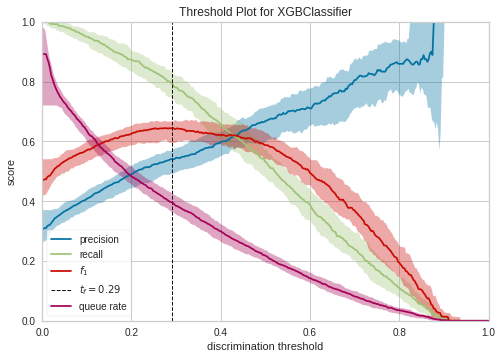

In [ ]:
best_xgb = XGBClassifier()
model = best_xgb.fit(X_train,Y_train)

telecom_churn_prediction(best_xgb, X_train, X_test, Y_train, Y_test, "features", threshold_plot=True)

In [ ]:
joblib.dump(model, '/my_model')

['/my_model']